In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss, PinballLoss
from model.model import LSTM, LinearNet, QuantileNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

torch.manual_seed(0)

#### Import data and set quantiles

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

## LSTM

In [3]:
# lookback periods
slide = 6

In [4]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all = FrameTorch(data_non_spread)
# split data
frametorch_all.split_data()
# scale datag
frametorch_all.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

In [5]:
# number of inputs and outputs
n_inputs = frametorch_all.data.shape[1] - 1
n_outputs = len(quantiles)

In [6]:
# model
quantilenet_smooth = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_smooth.parameters(), lr=0.0003)
# trainer class
trainer_smooth = Trainer(quantilenet_smooth, criterion, optimizer)

#### TRAIN DE MODEL

In [7]:
quantilenet_smooth = trainer_smooth.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

epoch: 0 train loss: 1.152 val loss: 0.726
epoch: 100 train loss: 0.097 val loss: 0.105
epoch: 200 train loss: 0.088 val loss: 0.098
epoch: 300 train loss: 0.085 val loss: 0.093


## MLP

In [8]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_non_spread = FrameTorch(data_non_spread)
# split data
frametorch_non_spread.split_data()
# scale data
frametorch_non_spread.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_non_spread.data_to_loader()

#### MODEL PREPARATION

In [9]:
# number of inputs and outputs
n_inputs = frametorch_non_spread.data.shape[1] - 1
n_outputs = len(quantiles)

In [12]:
# model
quantilenet_non_spread = QuantileNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_non_spread.parameters(), lr=0.0003)
# trainer class
trainer_non_spread = Trainer(quantilenet_non_spread, criterion, optimizer)

#### TRAIN DE MODEL

In [13]:
quantilenet_non_spread = trainer_non_spread.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

epoch: 0 train loss: 0.525 val loss: 0.246
epoch: 100 train loss: 0.093 val loss: 0.104
epoch: 200 train loss: 0.085 val loss: 0.104


## Linear

In [14]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_linear = FrameTorch(data_non_spread)
# split data
frametorch_linear.split_data()
# scale data
frametorch_linear.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_linear.data_to_loader()

In [15]:
# number of inputs and outputs
n_inputs = frametorch_linear.data.shape[1] - 1
n_outputs = len(quantiles)

In [16]:
# model
model_linear = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(model_linear.parameters(), lr=0.0003)
# trainer class
trainer_linear = Trainer(model_linear, criterion, optimizer)

In [17]:
model_linear = trainer_linear.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

epoch: 0 train loss: 0.534 val loss: 0.284
epoch: 100 train loss: 0.125 val loss: 0.127
epoch: 200 train loss: 0.123 val loss: 0.125
epoch: 300 train loss: 0.122 val loss: 0.124
epoch: 400 train loss: 0.121 val loss: 0.123


## COMPARE MODELS

In [18]:
# lsmt
train_loss_lstm = pd.Series(trainer_smooth.train_losses[1:])
val_loss_lstm = pd.Series(trainer_smooth.val_losses)
# mlp
train_loss_mlp = pd.Series(trainer_non_spread.train_losses[1:])
val_loss_mlp = pd.Series(trainer_non_spread.val_losses)
# linear
train_loss_linear = pd.Series(trainer_linear.train_losses[1:])
val_loss_linear = pd.Series(trainer_linear.val_losses)

# aggregate
train_loss = pd.concat(
    [train_loss_lstm, train_loss_mlp, train_loss_linear], 
    axis=1, 
    keys=['LSTM', 'MLP', 'LINEAR']
)
validation_loss = pd.concat(
    [val_loss_lstm, val_loss_mlp, val_loss_linear], 
    axis=1, 
    keys=['LSTM', 'MLP', 'LINEAR']
)

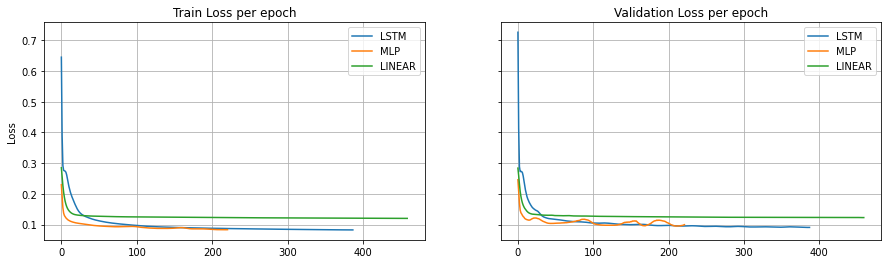

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)

train_loss.plot(ax=ax[0])
validation_loss.plot(ax=ax[1])

ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[0].grid()

ax[1].set_title('Validation Loss per epoch')
ax[1].grid()

### Predictions

In [20]:
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

# validation input and target
inputs, target_lstm = val_loader.dataset.inputs, val_loader.dataset.target
y_test_lstm = pd.Series(target_lstm.squeeze().tolist())

# quantilenet predictions
_y_pred_lstm = trainer_smooth.best_model(inputs)
y_pred_lstm = pd.DataFrame(_y_pred_lstm.tolist(), columns=quantiles.tolist())

In [21]:
train_loader, val_loader, test_loader = frametorch_non_spread.data_to_loader()

# validation input and target
inputs, target_mlp = val_loader.dataset.inputs, val_loader.dataset.target
y_test_mlp = pd.Series(target_mlp.squeeze().tolist())

# mlp predictions
_y_pred_mlp = trainer_non_spread.best_model(inputs)
y_pred_mlp = pd.DataFrame(_y_pred_mlp.tolist(), columns=quantiles.tolist())


In [22]:
train_loader, val_loader, test_loader = frametorch_linear.data_to_loader()

# validation input and target
inputs, target_linear = val_loader.dataset.inputs, val_loader.dataset.target
y_test_linear = pd.Series(target_linear.squeeze().tolist())

# linear predictions
_y_pred_linear = trainer_linear.best_model(inputs)
y_pred_linear = pd.DataFrame(_y_pred_linear.tolist(), columns=quantiles.tolist())

## Scores

In [23]:
scores_lstm = get_scores(_y_pred_lstm, target_lstm, quantiles)
scores_mlp = get_scores(_y_pred_mlp, target_mlp, quantiles)
scores_linear = get_scores(_y_pred_linear, target_mlp, quantiles)

final_scores = pd.concat(
    [scores_lstm, scores_mlp, scores_linear], axis=1, keys=['LSTM model', 'MLP model', 'Linear model']
)
final_scores

,LSTM model,MLP model,Linear model
QS,0.086560,0.095063,0.116049
IS,0.301852,0.327542,0.391499
Sharpnees,0.197225,0.201968,0.305717
ACE,1.548798,0.894694,1.459759


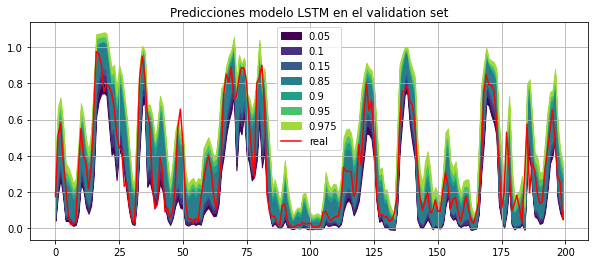

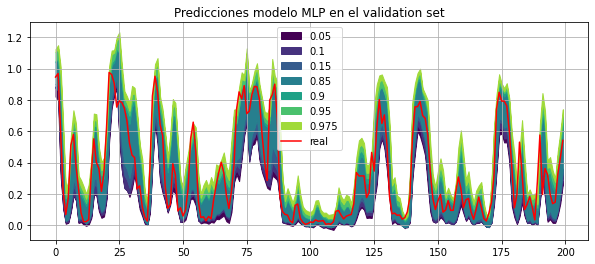

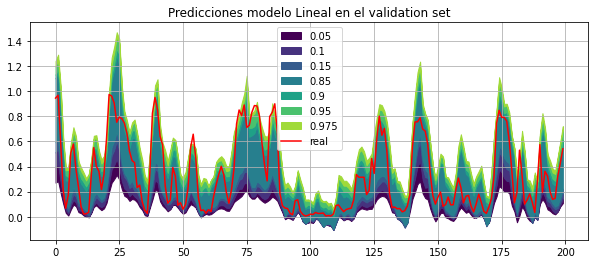

In [24]:
n_quantiles = len(quantiles)
legends = round(pd.Series(quantiles.tolist()), 3).to_list()[1:] + ['real']

viridis = cm.get_cmap('viridis', n_quantiles)
n_days_back = 200

fig, ax = plt.subplots(figsize=(10, 4))

# lstm plot
for i in range(n_quantiles-1):
    ax.fill_between(
        y_pred_lstm.index[:n_days_back], 
        y_pred_lstm[quantiles[i].item()][:n_days_back], 
        y_pred_lstm[quantiles[i+1].item()][:n_days_back], 
        color=viridis.colors[i]
    )  
y_test_lstm[:n_days_back].plot(color='red', ax=ax)
ax.set_title('Predicciones modelo LSTM en el validation set')
ax.grid()
ax.legend(legends)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))

# mlp plot
for i in range(n_quantiles-1):
    ax.fill_between(
        y_pred_mlp.index[:n_days_back], 
        y_pred_mlp[quantiles[i].item()][:n_days_back], 
        y_pred_mlp[quantiles[i+1].item()][:n_days_back], 
        color=viridis.colors[i]
    )
y_test_mlp[:n_days_back].plot(color='red', ax=ax)
ax.set_title('Predicciones modelo MLP en el validation set')
ax.grid()
ax.legend(legends)
plt.show()


fig, ax = plt.subplots(figsize=(10, 4))
# linear plot
for i in range(n_quantiles-1):
    ax.fill_between(
        y_pred_linear.index[:n_days_back], 
        y_pred_linear[quantiles[i].item()][:n_days_back], 
        y_pred_linear[quantiles[i+1].item()][:n_days_back], 
        color=viridis.colors[i]
    )
y_test_mlp[:n_days_back].plot(color='red', ax=ax)
ax.set_title('Predicciones modelo Lineal en el validation set')
ax.grid()
ax.legend(legends)